In [1]:
import pandas as pd

from data_preparation import (
    download_gios_archive,
    reformat_raw_dfs,
    download_updated_metadata,
    build_station_code_mapping,
    update_station_names_metadata,
    update_station_names_data,
    add_station_info,
    combine_metadata_frames,
    combine_data_frames,
)
from statistics_calculation import (
    analyze_raw_df,
    check_timestamps,
    report_nan_runs,
    monthly_avg_with_nan_threshold,
    hourly_to_daily_30d_sma,
    average_by_city,
    count_days_over_threshold,
)
from visualizations import (
    plot_monthly_avg_station_per_year,
    plot_monthly_avg_station_mean_std_per_year,
    plot_monthly_avg_station_comparison,
    plot_monthly_avg_station_std_comparison,
    plot_daily_sma_per_year,
    plot_daily_sma_mean_std_per_year,
    plot_daily_sma_comparison_years,
    plot_city_monthly_averages,
    plot_city_monthly_heatmaps,
    plot_extreme_stations_days_over,
)


# Przygotowanie danych

## Pobieranie surowych danych

Lekko zmodyfikowana funkcja: sprawdzam hashe (wpisane jednorazowo) dla pełnej odtwarzalności (reproducibility)

Ponadto uproszczona sygnatura funkcji pobierającej - podajemy tylko rok

In [2]:
df2014 = download_gios_archive(2014)
df2019 = download_gios_archive(2019)
df2024 = download_gios_archive(2024)

/opt/conda/lib/python3.11/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


## Sprawdzenie pobranych danych

In [3]:
meta_keys = ["Nr", "Kod stacji", "Wskaźnik",
             "Czas uśredniania", "Jednostka", "Kod stanowiska"]

for i, (year, year_df) in enumerate({"2014": df2014, "2019": df2019, "2024": df2024}.items()):
    print(f"Sanity check for raw {year} data:\n")
    print(analyze_raw_df(year_df, meta_keys))
    print(check_timestamps(year_df, meta_keys, 'H'))
    print(f"\n\n")

Sanity check for raw 2014 data:

{'shape': {'rows': 8763, 'columns': 36}, 'timestamp_counts': {'timestamp_rows': 8760, 'metadata_rows': 3, 'stations': 35}, 'uniqueness': {'Nr': {'all_unique': None, 'duplicates': None}, 'Kod stacji': {'all_unique': True, 'duplicates': None}, 'Kod stanowiska': {'all_unique': None, 'duplicates': None}}, 'unique_values': {'Czas uśredniania': ['1g'], 'Wskaźnik': ['PM2.5']}, 'nan_by_station_top10':    station_column      station_code  nan_percent
0              21      PdSuwPulaski    43.481735
1               2   KpAirpWiktorowo    35.228311
2               5  KpTorunDziewulsk    24.406393
3               4  KpBydgWarszawska    20.684932
4              24         Pm.AM12.a    15.650685
5               8   LuZgoraWIOS_AUT    14.760274
6              20    PdBialyMiejska    12.465753
7              19        OpKkozle1a    12.431507
8               3      KpBydgPlPozn    12.340183
9              34     ZpSzczecin001     9.143836}
{'summary': {'n_timestamp_rows

## Zmiana formatu dataframe'ów przed dalszym procesowaniem

In [4]:
meta_keys = ["Nr", "Kod stacji", "Wskaźnik",
             "Czas uśredniania", "Jednostka", "Kod stanowiska"]

meta2014, data2014 = reformat_raw_dfs(df2014, meta_keys)
meta2019, data2019 = reformat_raw_dfs(df2019, meta_keys)
meta2024, data2024 = reformat_raw_dfs(df2024, meta_keys)

In [5]:
meta2014

,Kod stacji,Wskaźnik,Czas uśredniania
1,DsWrocWisA,PM2.5,1g
2,KpAirpWiktorowo,PM2.5,1g
3,KpBydgPlPozn,PM2.5,1g
4,KpBydgWarszawska,PM2.5,1g
5,KpTorunDziewulsk,PM2.5,1g
6,LdLodzWIOSACzernik,PM2.5,1g
7,LdZgierzWIOSAMielcza,PM2.5,1g
8,LuZgoraWIOS_AUT,PM2.5,1g
9,MpKrakowWIOSAKra6117,PM2.5,1g
10,MpKrakowWIOSBuja6119,PM2.5,1g


## Aktualizacja nazw stacji

In [6]:
updated_metadata_df = download_updated_metadata()


In [7]:
code_map = build_station_code_mapping(updated_metadata_df)

[mapping] 1133 current codes, 295 distinct old codes


In [8]:
updated_metadata_df.to_csv("test2.csv")

In [9]:
meta2014u = update_station_names_metadata(meta2014, updated_metadata_df, code_map, label="2014")
meta2019u = update_station_names_metadata(meta2019, updated_metadata_df, code_map, label="2019")
meta2024u = update_station_names_metadata(meta2024, updated_metadata_df, code_map, label="2024")

[2014] total stations (rows): 35
[2014]   current names (already new): 1
[2014]   updated from old -> new:       34
[2014]   unmatched (not in mapping):   0
[2014] updated codes (old -> new):
                old_code      new_code
0             DsWrocWisA  DsWrocAlWisn
1        KpAirpWiktorowo  KpWiktorowoG
2           KpBydgPlPozn  KpBydPlPozna
3       KpBydgWarszawska  KpBydWarszaw
4       KpTorunDziewulsk  KpToruDziewu
5     LdLodzWIOSACzernik  LdLodzCzerni
6   LdZgierzWIOSAMielcza  LdZgieMielcz
7        LuZgoraWIOS_AUT  LuZielKrotka
8   MpKrakowWIOSAKra6117  MpKrakAlKras
9   MpKrakowWIOSBuja6119  MpKrakBujaka
10  MpKrakowWIOSBulw6118  MpKrakBulwar
11       MzLegionZegIMGW  MzLegZegrzyn
12           MzPlockReja  MzPlocMiReja
13        MzRadomTochter  MzRadTochter
14        MzSiedlceKonar  MzSiedKonars
15        MzWarNiepodKom  MzWarAlNiepo
16        MzWarszUrsynow  MzWarWokalna
17      MzZyrardRoosevel  MzZyraRoosev
18            OpKkozle1a  OpKKozBSmial
19        PdBialyMiejska  Pd

In [10]:
data2014u = update_station_names_data(data2014, code_map, label="2014")
data2019u = update_station_names_data(data2019, code_map, label="2019")
data2024u = update_station_names_data(data2024, code_map, label="2024")

[2014] measurements: 34 station columns renamed
[2014] renamed columns (old -> new):
                old_code      new_code
0             DsWrocWisA  DsWrocAlWisn
1        KpAirpWiktorowo  KpWiktorowoG
2           KpBydgPlPozn  KpBydPlPozna
3       KpBydgWarszawska  KpBydWarszaw
4       KpTorunDziewulsk  KpToruDziewu
5     LdLodzWIOSACzernik  LdLodzCzerni
6   LdZgierzWIOSAMielcza  LdZgieMielcz
7        LuZgoraWIOS_AUT  LuZielKrotka
8   MpKrakowWIOSAKra6117  MpKrakAlKras
9   MpKrakowWIOSBuja6119  MpKrakBujaka
10  MpKrakowWIOSBulw6118  MpKrakBulwar
11       MzLegionZegIMGW  MzLegZegrzyn
12           MzPlockReja  MzPlocMiReja
13        MzRadomTochter  MzRadTochter
14        MzSiedlceKonar  MzSiedKonars
15        MzWarNiepodKom  MzWarAlNiepo
16        MzWarszUrsynow  MzWarWokalna
17      MzZyrardRoosevel  MzZyraRoosev
18            OpKkozle1a  OpKKozBSmial
19        PdBialyMiejska  PdBialWaszyn
20   PkPrzemyslWIOSGrunw  PkPrzemGrunw
21               Pm.a08a  PmGdaLeczkow
22             Pm.

## Uzupełnienie i rozszerzenie metadanych

In [11]:
meta2014ux = add_station_info(meta2014u, updated_metadata_df, label="2014")
meta2019ux = add_station_info(meta2019u, updated_metadata_df, label="2019")
meta2024ux = add_station_info(meta2024u, updated_metadata_df, label="2024")

## Połączenie danych dla różnych lat

Tworzymy połączony zbiór dla niniejszego opracowania

In [12]:
metadata_combined, diag1 = combine_metadata_frames([meta2014ux, meta2019ux, meta2024ux])

diag1

[meta 0] unique stations: 35
[meta 1] unique stations: 63
[meta 2] unique stations: 96
[meta] stations present in ALL years: 23


{'DsWrocAlWisn',
 'KpBydPlPozna',
 'LdLodzCzerni',
 'LdZgieMielcz',
 'LuZielKrotka',
 'MpKrakAlKras',
 'MpKrakBulwar',
 'MzLegZegrzyn',
 'MzPlocMiReja',
 'MzRadTochter',
 'MzSiedKonars',
 'MzWarAlNiepo',
 'MzWarWokalna',
 'MzZyraRoosev',
 'OpKKozBSmial',
 'PkPrzemGrunw',
 'PmGdaLeczkow',
 'SlKatoKossut',
 'SlZlotPotLes',
 'WmOlsPuszkin',
 'WpKaliSawick',
 'ZpSzczAndrze',
 'ZpSzczPilsud'}

In [13]:
data_combined, diag2 = combine_data_frames([data2014u, data2019u, data2024u])

diag2

[data 0] station columns: 35
[data 1] station columns: 63
[data 2] station columns: 96
[data] stations present in ALL years: 23


['DsWrocAlWisn',
 'KpBydPlPozna',
 'LdLodzCzerni',
 'LdZgieMielcz',
 'LuZielKrotka',
 'MpKrakAlKras',
 'MpKrakBulwar',
 'MzLegZegrzyn',
 'MzPlocMiReja',
 'MzRadTochter',
 'MzSiedKonars',
 'MzWarAlNiepo',
 'MzWarWokalna',
 'MzZyraRoosev',
 'OpKKozBSmial',
 'PkPrzemGrunw',
 'PmGdaLeczkow',
 'SlKatoKossut',
 'SlZlotPotLes',
 'WmOlsPuszkin',
 'WpKaliSawick',
 'ZpSzczAndrze',
 'ZpSzczPilsud']

In [14]:
assert not diag1.isdisjoint(diag2)

## Czyszczenie / ektrapolacja brakujących danych

In [15]:
report = report_nan_runs(data_combined, top_k=3)

print("Total stations:", report["total_stations"])
print("Stations with any NaN:", report["stations_with_any_nan"])

for station in report["nan_runs"].keys():
    print(station)
    print(report["nan_runs"][station])

Total stations: 23
Stations with any NaN: 23
DsWrocAlWisn
                start                 end    length
0 2014-03-05 16:00:00 2014-03-10 13:00:00  4.916667
1 2024-05-24 08:00:00 2024-05-27 10:00:00  3.125000
2 2014-11-03 06:00:00 2014-11-04 10:00:00  1.208333
KpBydPlPozna
                start                 end    length
0 2014-09-25 19:00:00 2014-09-29 11:00:00  3.708333
1 2019-08-13 09:00:00 2019-08-15 23:00:00  2.625000
2 2014-12-18 08:00:00 2014-12-20 17:00:00  2.416667
LdLodzCzerni
                start                 end     length
0 2024-04-28 11:00:00 2024-05-18 21:00:00  20.458333
1 2014-12-11 13:00:00 2014-12-23 12:00:00  12.000000
2 2019-12-24 15:00:00 2019-12-27 17:00:00   3.125000
LdZgieMielcz
                start                 end    length
0 2019-07-27 17:00:00 2019-08-01 16:00:00  5.000000
1 2024-11-29 18:00:00 2024-12-04 09:00:00  4.666667
2 2024-06-06 10:00:00 2024-06-10 07:00:00  3.916667
LuZielKrotka
                start                 end    length
0 

**Interpretacja**

Gdańsk i Siedlce mają wielomiesięczne przerwy w pomiarach.

W pozostałych miastach zdarzają się przerwy rzędu kilkunastu dni.

Jako, że mamy ograniczoną ilość danych - nie wyrzucam tych miast, nie uzupełniam luk.

Natomiast musimy pamiętać:
- Dla analizy miesięcznej: zignorować miesiące z większością dni NaN - niewiarygodna średnia
- Dla analizy dni z przekroczeniami: zignorować Gdańsk i Siedlce - wielomiesięczne luki zaniżają liczbę przekroczeń

## Zapisanie kopii Dataframe'ów na dysku

Surowe dane

In [16]:
df2014.to_csv("raw_data/raw_data_2014.csv.xz")
df2019.to_csv("raw_data/raw_data_2019.csv.xz")
df2024.to_csv("raw_data/raw_data_2024.csv.xz")

updated_metadata_df.to_csv("raw_data/raw_updated_metadata_20251122.csv.xz") # Uwaga - nie są to idealnie surowe dane - skasowaliśmy trailing space w nazwie jednej stacji

Oczyszczone dane

In [17]:
meta2014ux.to_csv("cleaned_data/metadata_2014.csv.xz")
meta2019ux.to_csv("cleaned_data/metadata_2019.csv.xz")
meta2024ux.to_csv("cleaned_data/metadata_2024.csv.xz")

data2014u.to_csv("cleaned_data/data_2014.csv.xz")
data2019u.to_csv("cleaned_data/data_2019.csv.xz")
data2024u.to_csv("cleaned_data/data_2024.csv.xz")

metadata_combined.to_csv("cleaned_data/pd1_dataset_metadata.csv.xz",index=False)
data_combined.to_csv("cleaned_data/pd1_dataset_data.csv.xz")

# Analiza

## Wczytanie danych

In [18]:
metadata_combined = pd.read_csv("cleaned_data/pd1_dataset_metadata.csv.xz")
data_combined = pd.read_csv("cleaned_data/pd1_dataset_data.csv.xz",index_col=0)

In [19]:
data_combined.head()

,DsWrocAlWisn,KpBydPlPozna,LdLodzCzerni,LdZgieMielcz,LuZielKrotka,MpKrakAlKras,MpKrakBulwar,MzLegZegrzyn,MzPlocMiReja,MzRadTochter,...,MzZyraRoosev,OpKKozBSmial,PkPrzemGrunw,PmGdaLeczkow,SlKatoKossut,SlZlotPotLes,WmOlsPuszkin,WpKaliSawick,ZpSzczAndrze,ZpSzczPilsud
2014-01-01 01:00:00,152.0,116.214424,81.029259,119.696114,NaN,104.0,64.0,44.44,NaN,58.67,...,NaN,115.0,48.175,58.4,104.0,32.0,84.121582,NaN,105.4890,109.0
2014-01-01 02:00:00,137.0,NaN,210.364670,70.337502,NaN,104.0,63.0,103.07,NaN,40.07,...,NaN,134.0,33.747,28.5,107.0,39.0,75.444382,82.5,149.7970,118.0
2014-01-01 03:00:00,129.0,NaN,66.425789,40.915695,NaN,91.0,62.0,74.91,NaN,32.72,...,NaN,137.0,30.622,27.0,114.0,43.0,34.427513,83.0,86.9602,120.0
2014-01-01 04:00:00,129.0,NaN,53.999668,37.817917,NaN,89.0,58.0,39.27,NaN,27.44,...,NaN,137.0,28.642,28.7,108.0,42.0,32.742474,73.1,74.8762,104.0
2014-01-01 05:00:00,105.0,NaN,52.239670,38.814861,NaN,83.0,55.0,26.51,NaN,28.01,...,NaN,136.0,27.781,25.7,88.0,40.0,32.714367,74.9,61.9866,96.0


In [20]:
metadata_combined.head()

,Kod stacji,Wskaźnik,Czas uśredniania,Stary Kod stacji,Typ stacji,Typ obszaru,Rodzaj stacji,Województwo,Miejscowość,Szerokość geograficzna,Długość geograficzna
0,DsWrocAlWisn,PM2.5,1g,DsWrocWisA,komunikacyjna,miejski,kontenerowa stacjonarna,DOLNOŚLĄSKIE,Wrocław,51.086225,17.012689
1,KpBydPlPozna,PM2.5,1g,KpBydgPlPozn,komunikacyjna,miejski,kontenerowa stacjonarna,KUJAWSKO-POMORSKIE,Bydgoszcz,53.121764,17.987906
2,LdLodzCzerni,PM2.5,1g,LdLodzWIOSACzernik,tło,miejski,kontenerowa stacjonarna,ŁÓDZKIE,Łódź,51.758050,19.529786
3,LdZgieMielcz,PM2.5,1g,LdZgierzWIOSAMielcza,tło,miejski,kontenerowa stacjonarna,ŁÓDZKIE,Zgierz,51.856692,19.421231
4,LuZielKrotka,PM2.5,1g,LuZgoraWIOS_AUT,tło,miejski,kontenerowa stacjonarna,LUBUSKIE,Zielona Góra,51.939783,15.518861


## Średnie miesięczne stacji

> Oblicz średnie miesięczne stężenie PM2.5 dla każdej stacji i roku

Średnie miesięczne stężenie dla każdej stacji rozumiem.
Natomiast "i roku" nie rozumiem.

Chodzi o stężenia miesięczne i roczne?

Średnie stężenie w danym roku we wszystkich stacjach?

In [21]:
monthly_avg_station = monthly_avg_with_nan_threshold(data_combined, max_nan_per_month=24*10)

In [22]:
monthly_avg_station.head()

,DsWrocAlWisn,KpBydPlPozna,LdLodzCzerni,LdZgieMielcz,LuZielKrotka,MpKrakAlKras,MpKrakBulwar,MzLegZegrzyn,MzPlocMiReja,MzRadTochter,...,MzZyraRoosev,OpKKozBSmial,PkPrzemGrunw,PmGdaLeczkow,SlKatoKossut,SlZlotPotLes,WmOlsPuszkin,WpKaliSawick,ZpSzczAndrze,ZpSzczPilsud
2014-01-31,42.797037,30.616434,35.407387,31.518199,NaN,60.350806,47.241565,39.815343,31.855108,40.485457,...,36.824947,42.847025,32.047507,15.574259,47.531587,25.105590,25.550652,42.099015,32.280684,32.398922
2014-02-28,38.649351,51.856173,45.704915,46.359747,33.748299,86.708955,62.591045,62.753609,50.473512,53.218289,...,55.307686,43.510433,51.465929,25.712251,57.502297,32.390863,40.799969,52.429559,22.655796,32.134731
2014-03-31,36.125000,40.556041,35.259896,36.861373,37.276358,54.498652,39.900135,47.863719,31.600595,43.391626,...,45.742247,45.567347,30.040347,15.098253,42.855405,21.564371,24.921921,53.279132,26.832721,37.271277
2014-04-30,25.353659,19.772776,23.474251,18.767278,23.778929,34.743300,24.543417,27.777273,20.852646,27.699527,...,26.113754,29.082759,20.732240,13.423333,26.925608,14.539735,17.748875,32.493501,15.903186,22.124302
2014-05-31,14.963925,11.903410,16.407493,11.068347,12.545727,19.547718,14.522849,14.622747,12.079019,14.581354,...,14.187658,16.551867,10.376133,10.499194,14.893387,8.812585,13.588730,17.961618,10.925751,12.351079


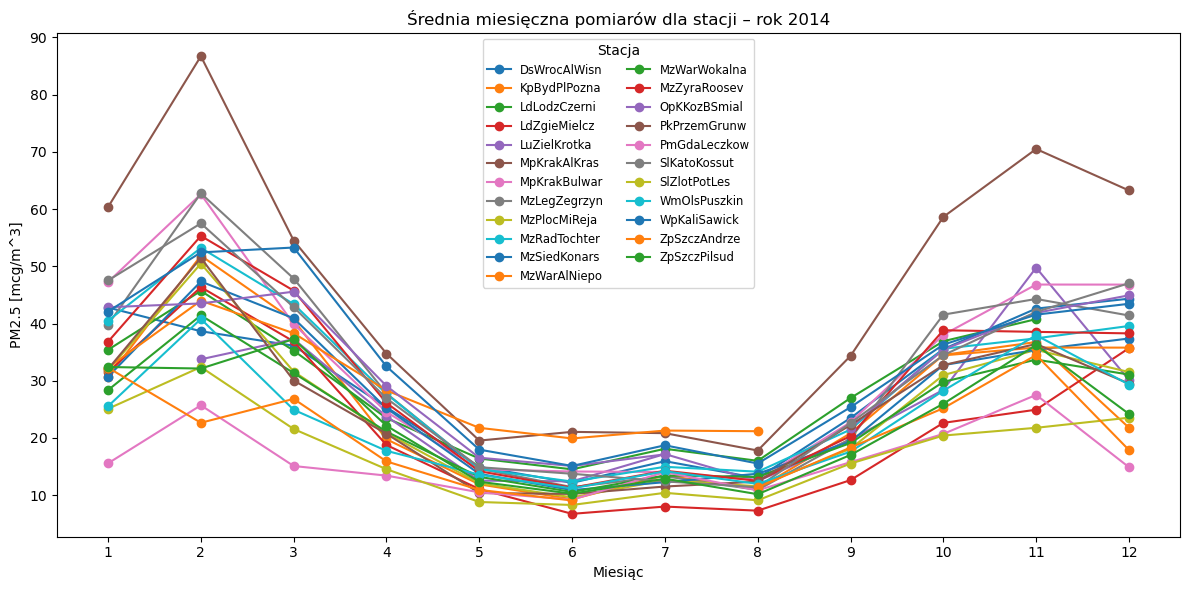

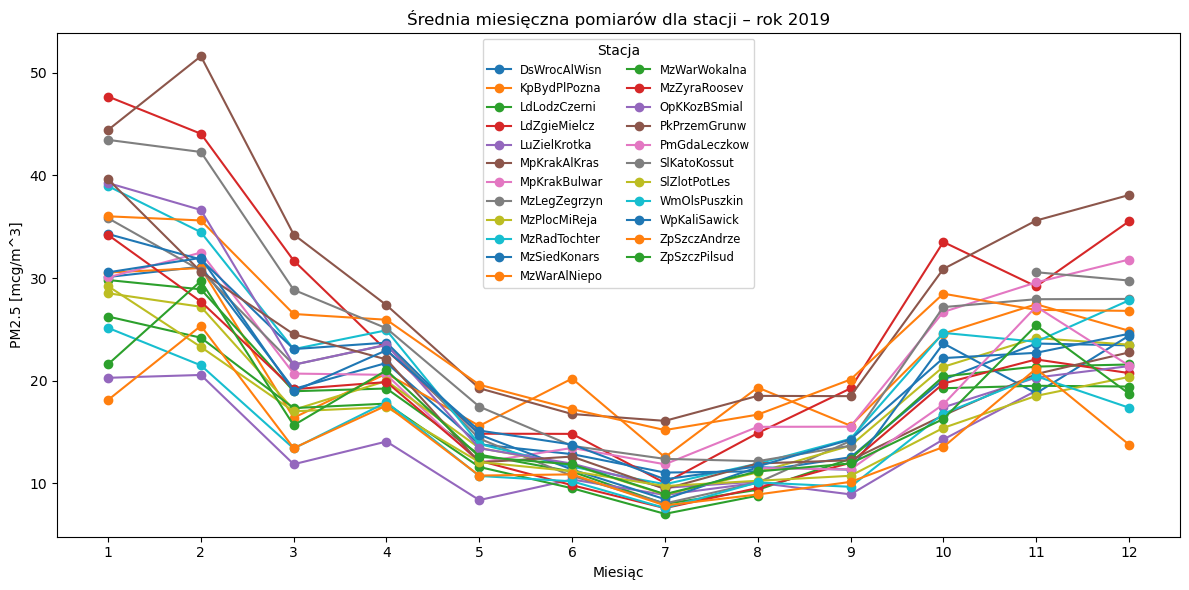

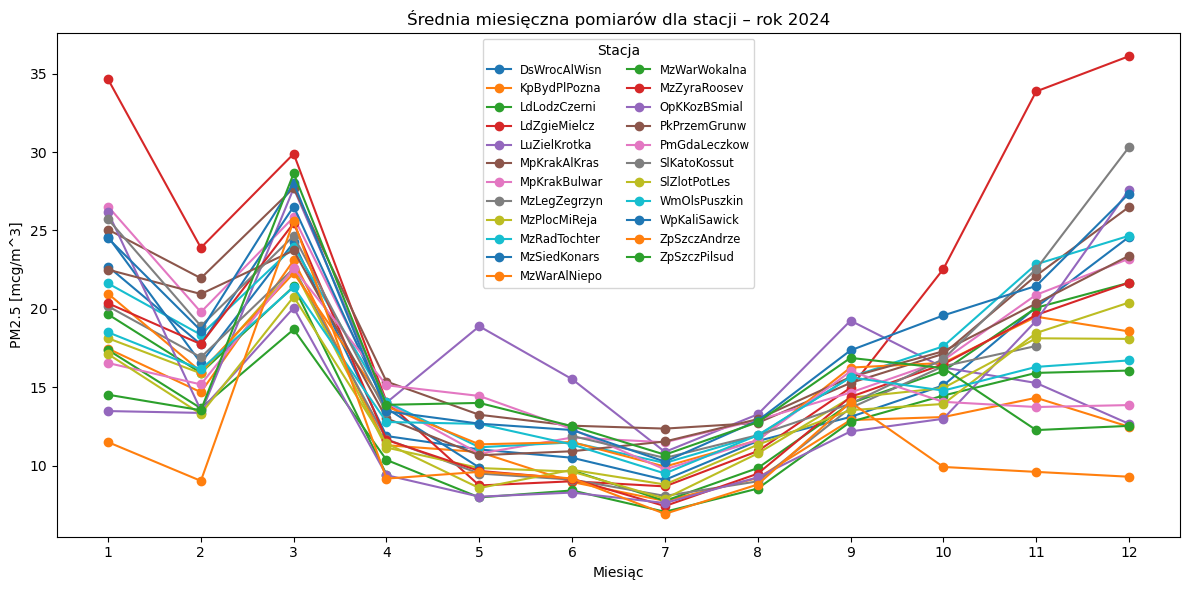

In [23]:
plot_monthly_avg_station_per_year(monthly_avg_station)


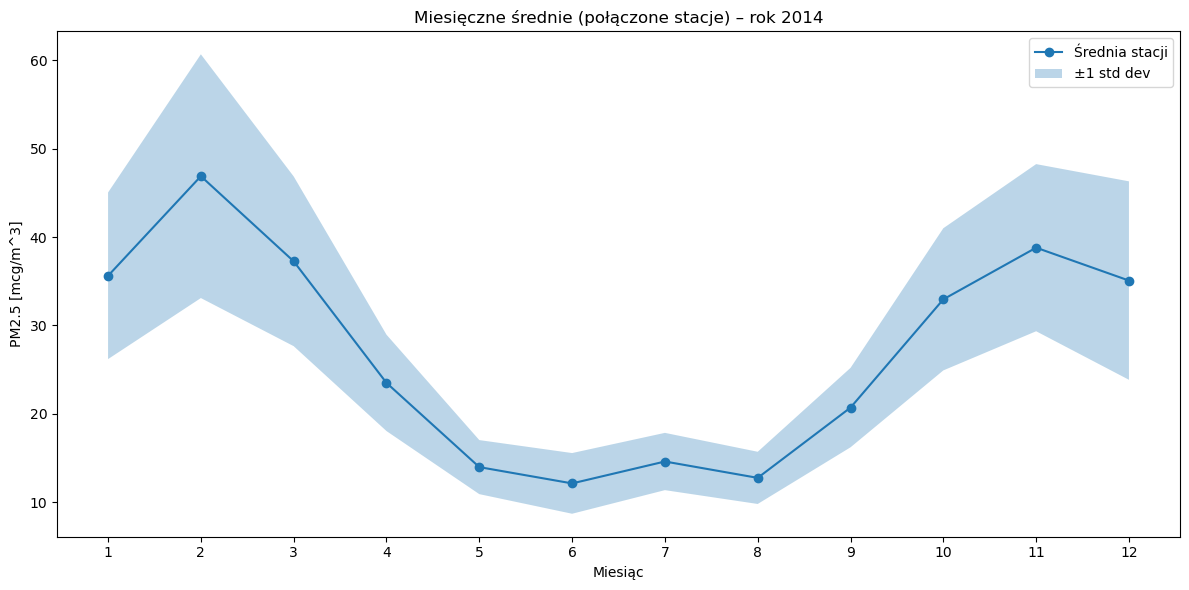

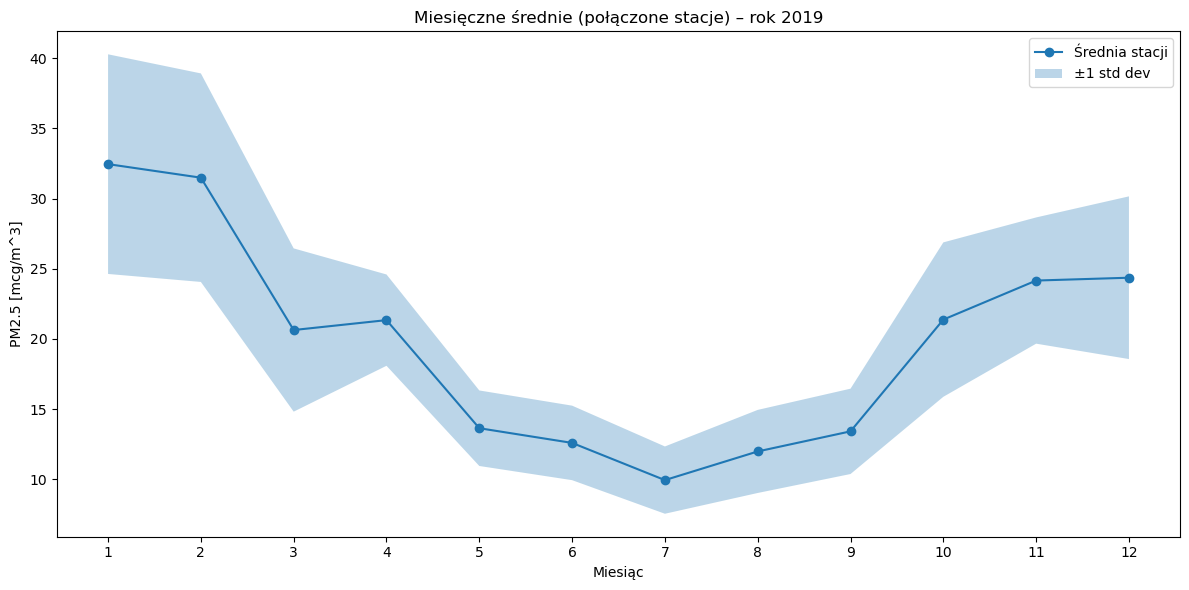

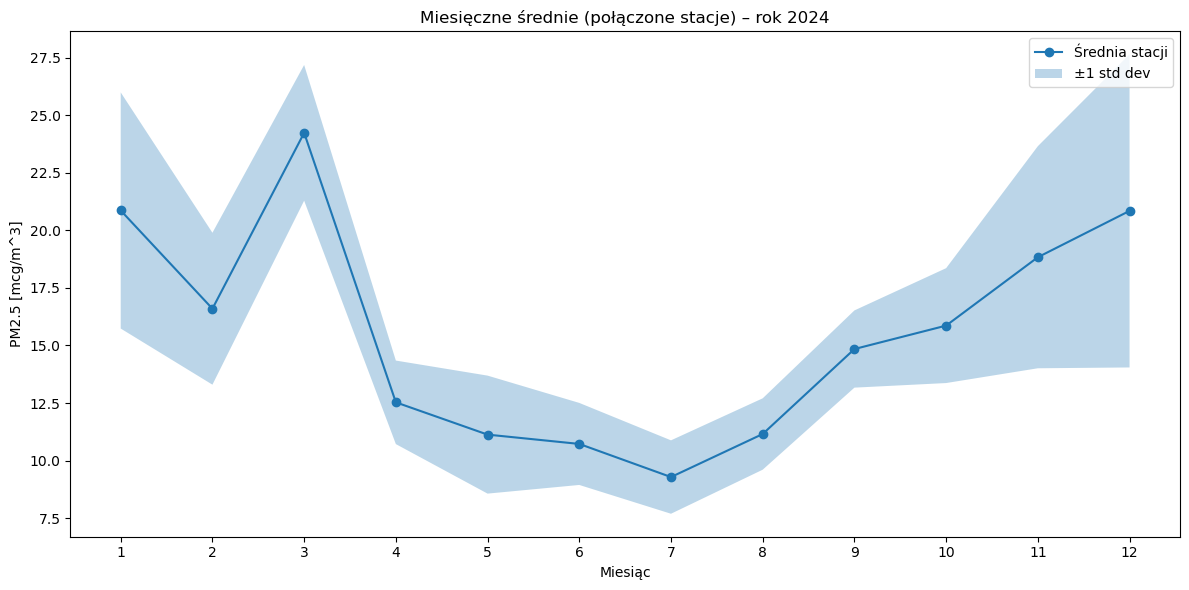

In [24]:
plot_monthly_avg_station_mean_std_per_year(monthly_avg_station)


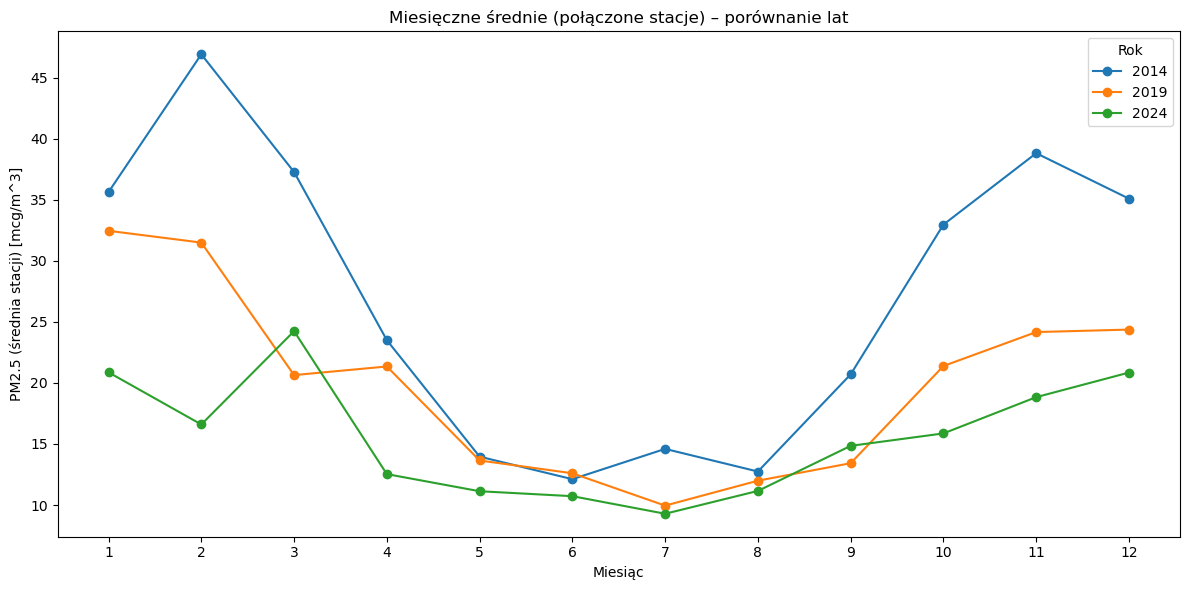

In [25]:
plot_monthly_avg_station_comparison(monthly_avg_station)


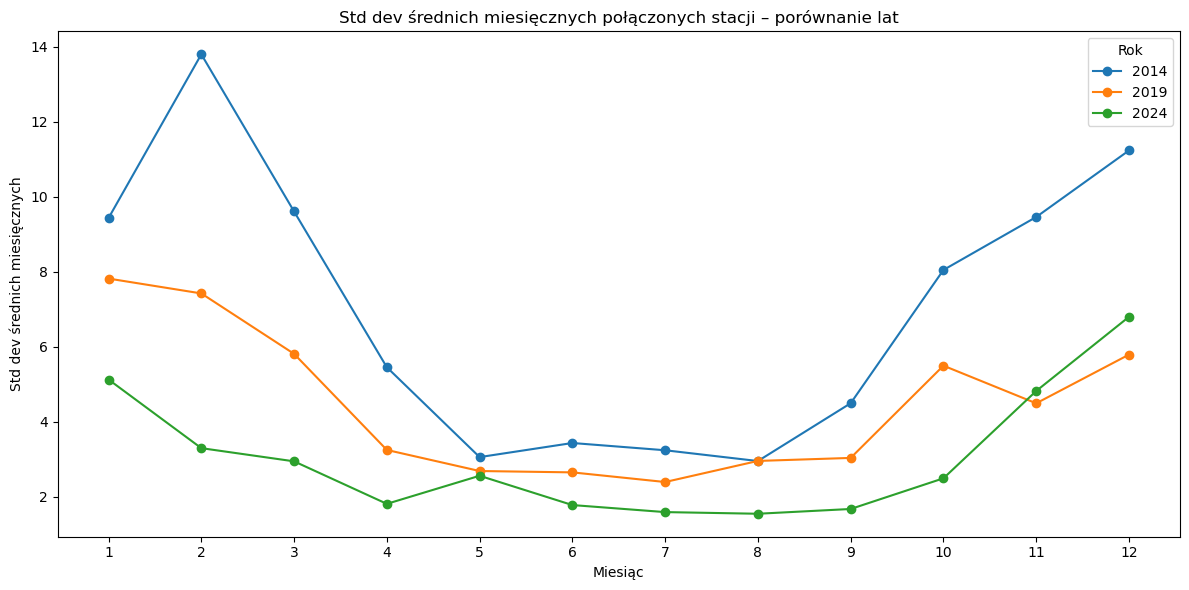

In [26]:
plot_monthly_avg_station_std_comparison(monthly_avg_station)


### SMA

In [27]:
daily_sma = hourly_to_daily_30d_sma(data_combined)
daily_sma.index = pd.to_datetime(daily_sma.index)

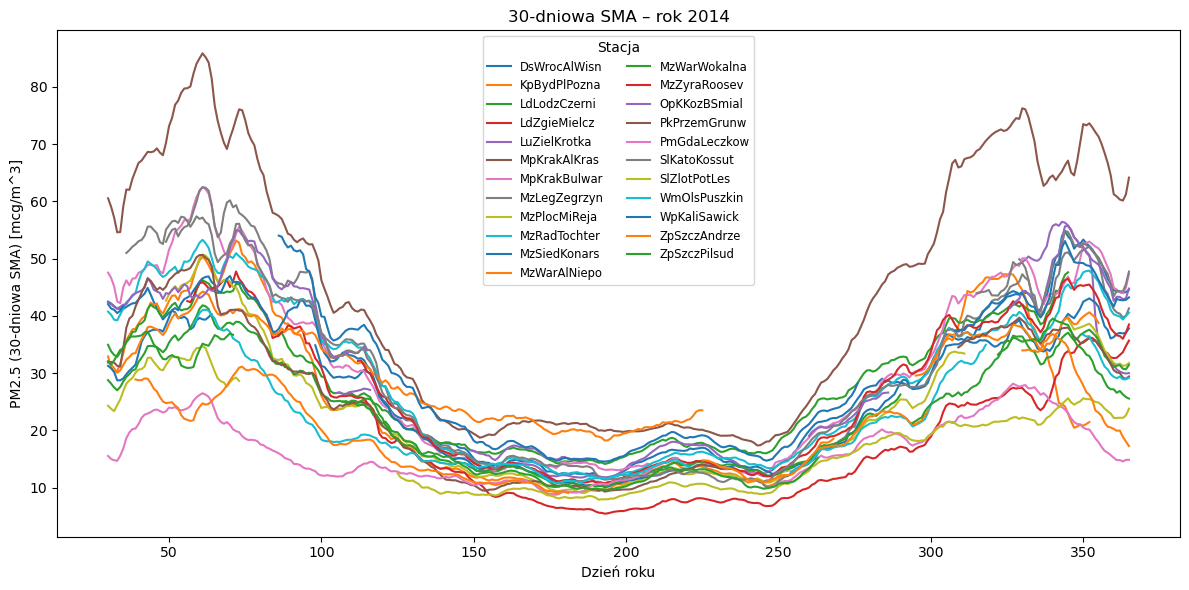

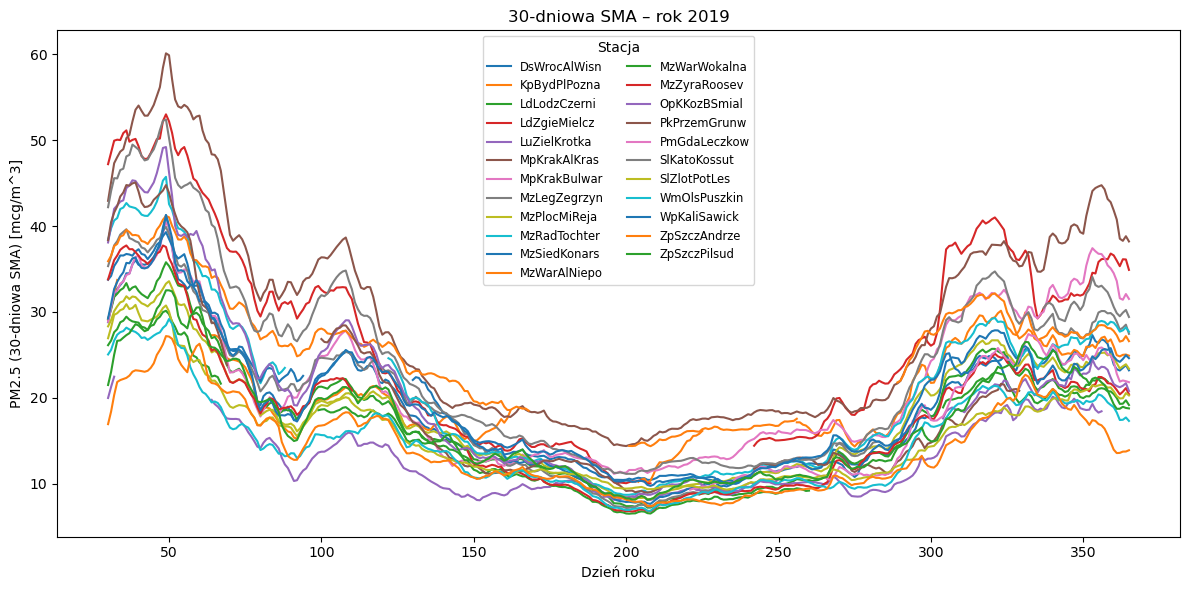

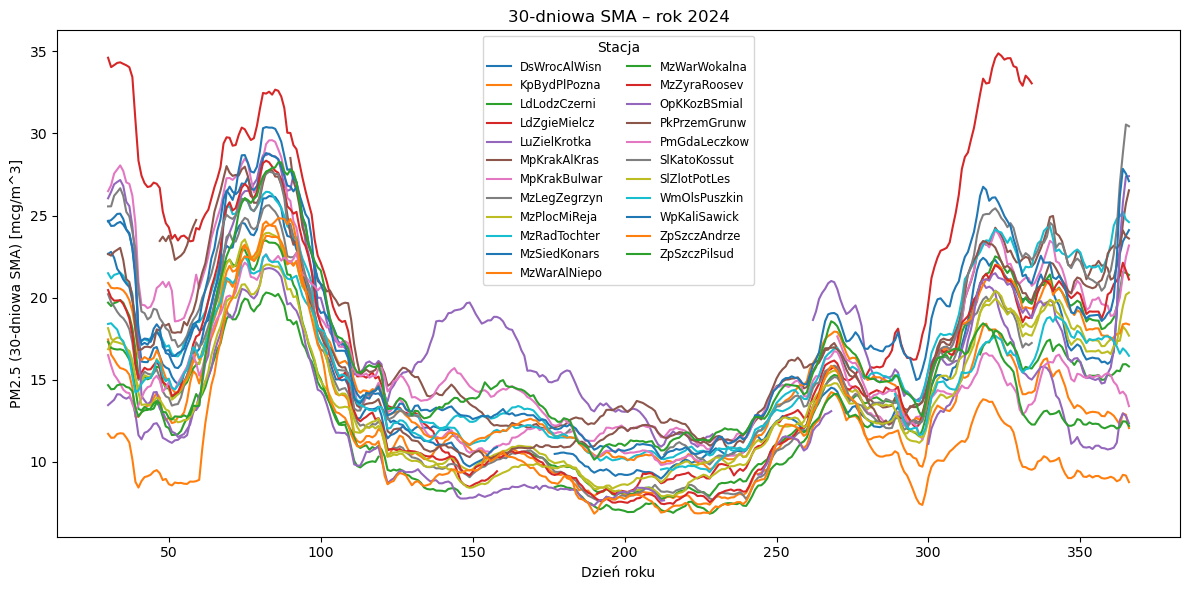

In [28]:
plot_daily_sma_per_year(daily_sma)


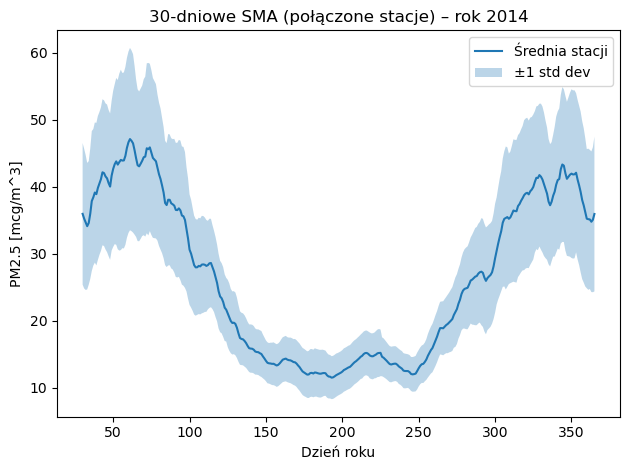

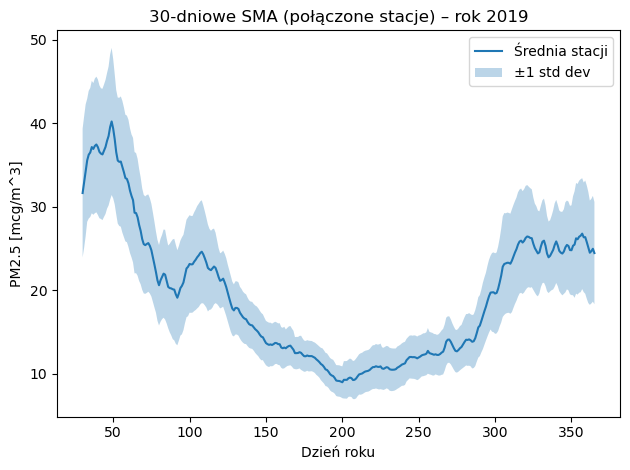

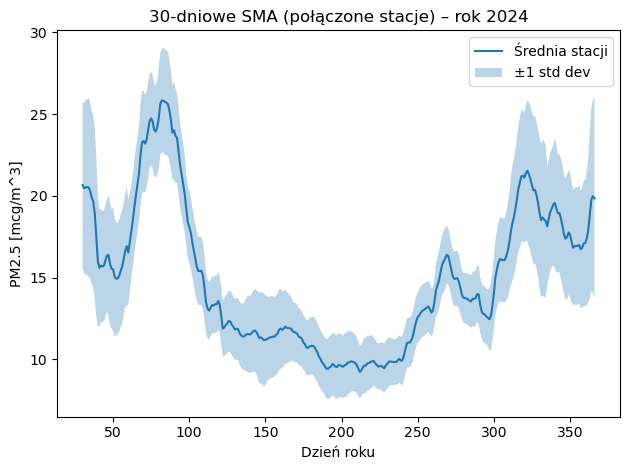

In [29]:
plot_daily_sma_mean_std_per_year(daily_sma)


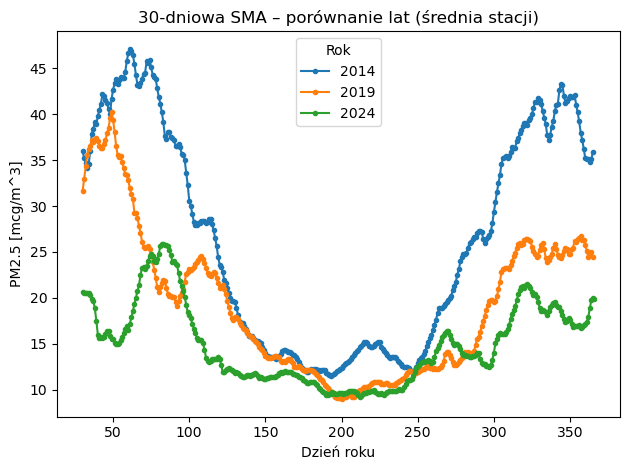

In [31]:
plot_daily_sma_comparison_years(daily_sma)


## Warszawa vs Katowice

In [32]:
city_data_combined = average_by_city(data_combined, metadata_combined)
city_data_combined.head()

/home/jovyan/work/repos/uni/Zaawansowane techniki programowania/projekt3/statistics_calculation.py:303: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_city = df.groupby(axis=1, by=col_cities).mean()


city,Bydgoszcz,Gdańsk,Kalisz,Katowice,Kraków,Kędzierzyn-Koźle,Legionowo,Olsztyn,Przemyśl,Płock,Radom,Siedlce,Szczecin,Warszawa,Wrocław,Zgierz,Zielona Góra,Złoty Potok,Łódź,Żyrardów
2014-01-01 01:00:00,116.214424,58.4,NaN,104.0,84.0,115.0,44.44,84.121582,48.175,NaN,58.67,28.24,107.2445,81.907899,152.0,119.696114,NaN,32.0,81.029259,NaN
2014-01-01 02:00:00,NaN,28.5,82.5,107.0,83.5,134.0,103.07,75.444382,33.747,NaN,40.07,19.63,133.8985,52.846215,137.0,70.337502,NaN,39.0,210.364670,NaN
2014-01-01 03:00:00,NaN,27.0,83.0,114.0,76.5,137.0,74.91,34.427513,30.622,NaN,32.72,15.39,103.4801,35.868930,129.0,40.915695,NaN,43.0,66.425789,NaN
2014-01-01 04:00:00,NaN,28.7,73.1,108.0,73.5,137.0,39.27,32.742474,28.642,NaN,27.44,15.27,89.4381,34.499468,129.0,37.817917,NaN,42.0,53.999668,NaN
2014-01-01 05:00:00,NaN,25.7,74.9,88.0,69.0,136.0,26.51,32.714367,27.781,NaN,28.01,17.45,78.9933,37.522977,105.0,38.814861,NaN,40.0,52.239670,NaN


In [33]:
monthly_avg_city = monthly_avg_with_nan_threshold(city_data_combined, max_nan_per_month=24*10)

In [34]:
monthly_avg_city

city,Bydgoszcz,Gdańsk,Kalisz,Katowice,Kraków,Kędzierzyn-Koźle,Legionowo,Olsztyn,Przemyśl,Płock,Radom,Siedlce,Szczecin,Warszawa,Wrocław,Zgierz,Zielona Góra,Złoty Potok,Łódź,Żyrardów
2014-01-31,30.616434,15.574259,42.099015,47.531587,53.805108,42.847025,39.815343,25.550652,32.047507,31.855108,40.485457,30.710269,30.648653,30.108373,42.797037,31.518199,NaN,25.105590,35.407387,36.824947
2014-02-28,51.856173,25.712251,52.429559,57.502297,74.578125,43.510433,62.753609,40.799969,51.465929,50.473512,53.218289,47.344554,27.378568,42.801541,38.649351,46.359747,33.748299,32.390863,45.704915,55.307686
2014-03-31,40.556041,15.098253,53.279132,42.855405,47.188844,45.567347,47.863719,24.921921,30.040347,31.600595,43.391626,40.910263,30.315625,34.825151,36.125000,36.861373,37.276358,21.564371,35.259896,45.742247
2014-04-30,19.772776,13.423333,32.493501,26.925608,29.664583,29.082759,27.777273,17.748875,20.732240,20.852646,27.699527,25.200014,19.254632,24.765423,25.353659,18.767278,23.778929,14.539735,23.474251,26.113754
2014-05-31,11.903410,10.499194,17.961618,14.893387,16.926075,16.551867,14.622747,13.588730,10.376133,12.079019,14.581354,13.727911,11.616565,17.449219,14.963925,11.068347,12.545727,8.812585,16.407493,14.187658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,9.209726,11.628857,12.873387,11.948790,12.806989,9.262936,9.005376,11.946774,12.971640,10.782907,11.917204,NaN,10.787634,10.077285,11.574059,10.932571,13.275719,11.338575,9.851478,9.493405
2024-09-30,12.913372,16.022270,17.357799,13.956111,14.965764,12.187442,13.684167,15.639441,15.655602,14.335278,15.653652,NaN,15.434653,14.524236,13.114571,14.973056,19.249787,13.546314,13.984844,14.392222
2024-10-31,13.104191,14.074832,19.584005,16.799194,16.930712,12.995296,16.339300,14.791233,17.301344,14.956081,17.613525,NaN,13.068683,15.329408,15.125575,22.542396,16.264714,13.939651,16.039838,16.474124
2024-11-30,14.332390,13.743611,21.465132,22.538056,21.511319,19.244861,17.635286,16.302778,20.348472,18.126287,22.847539,NaN,10.940833,17.741319,20.102646,33.866328,15.278151,18.464714,20.072308,19.610987


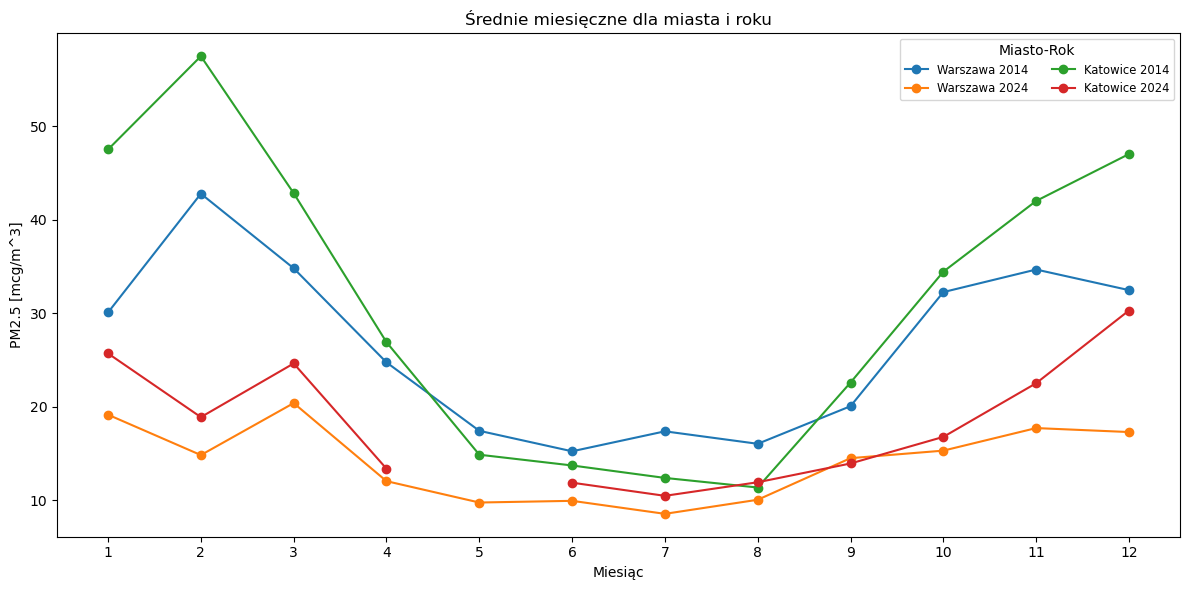

In [35]:
plot_city_monthly_averages(monthly_avg_city, ["Warszawa", "Katowice"], [2014, 2024])

## Heatmapy

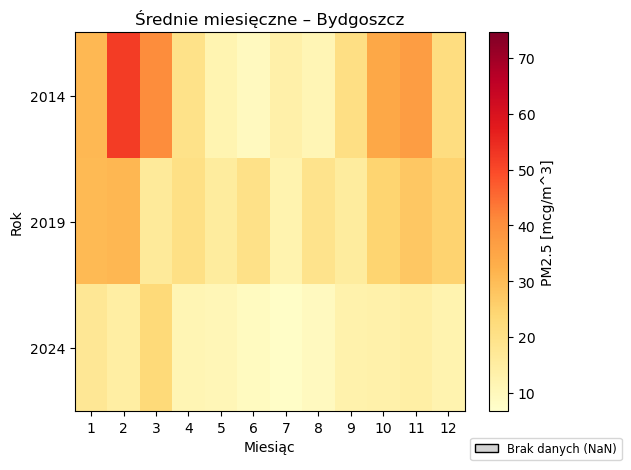

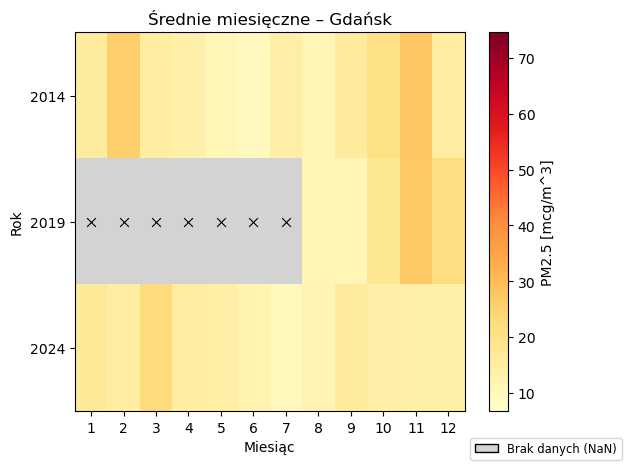

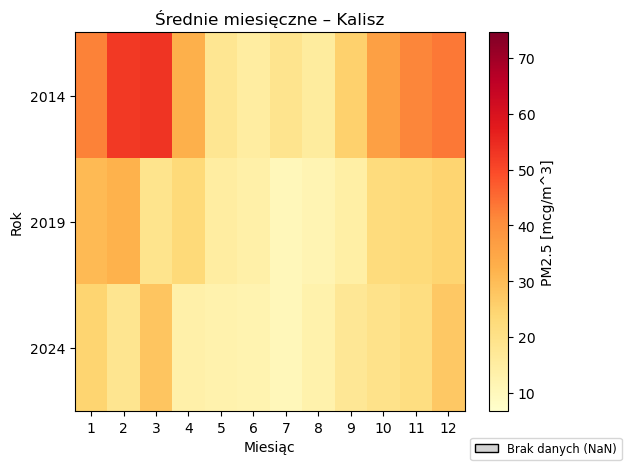

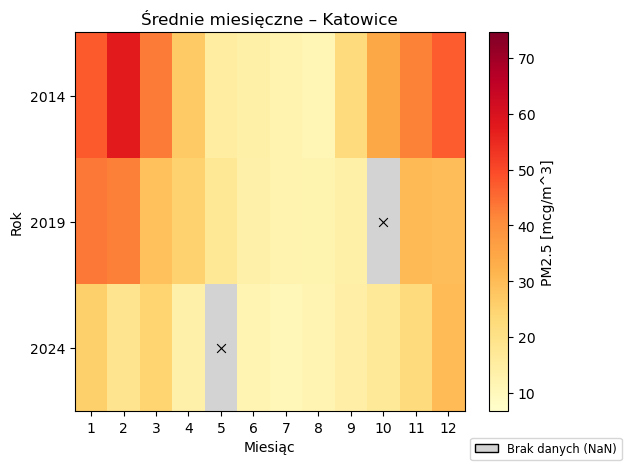

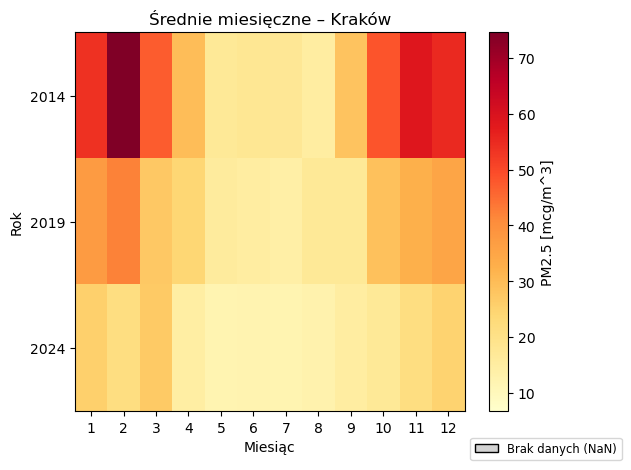

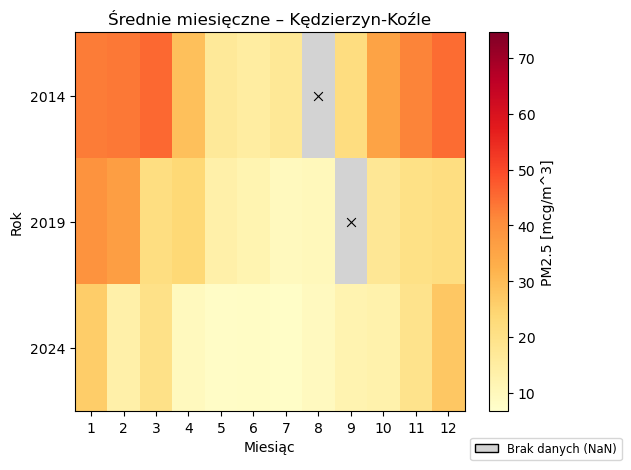

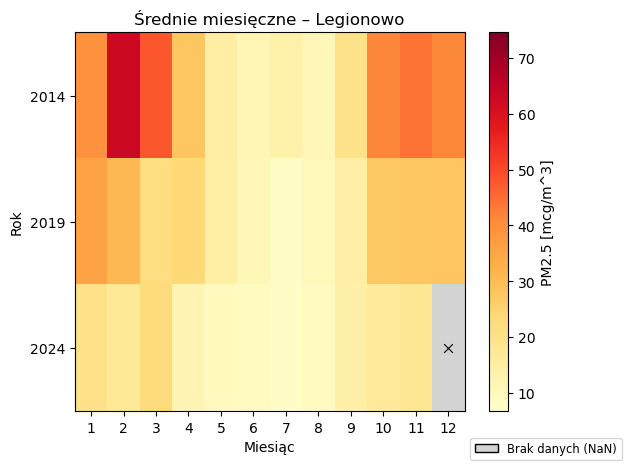

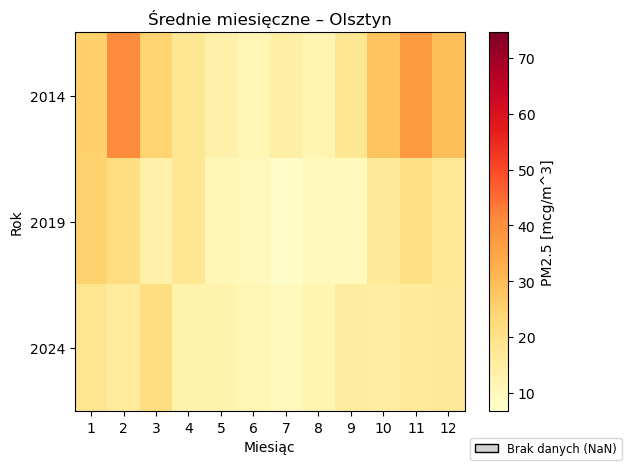

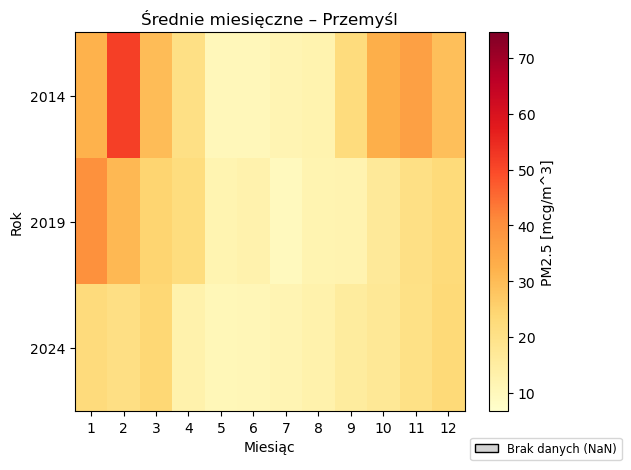

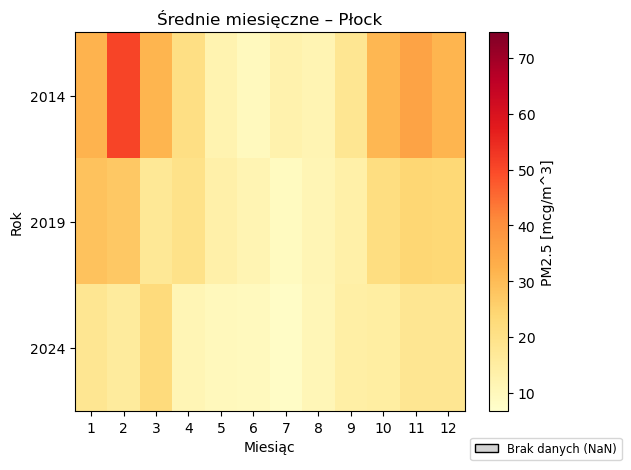

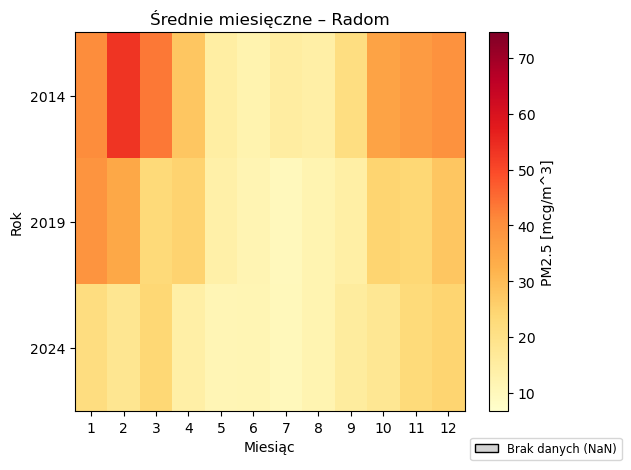

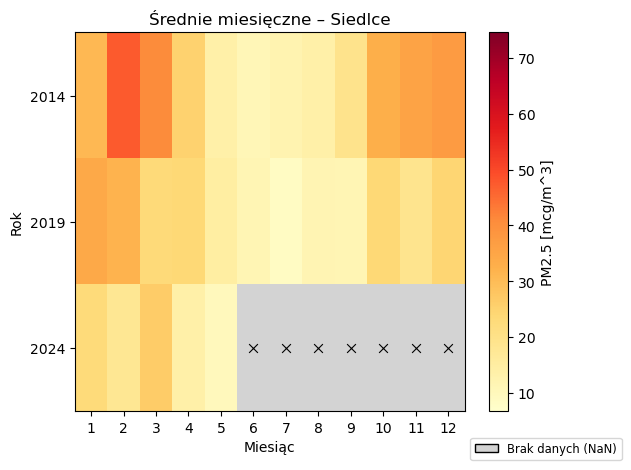

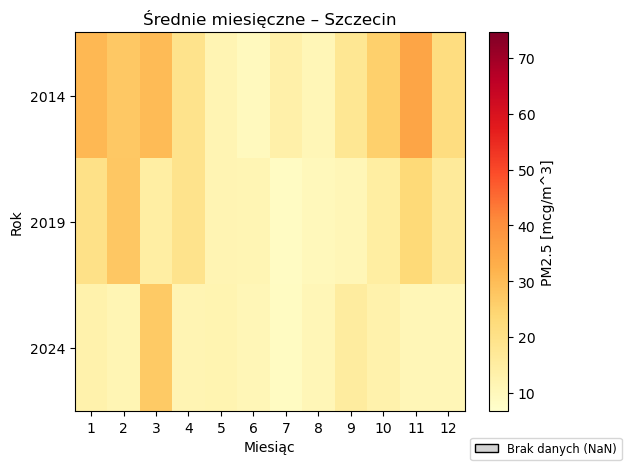

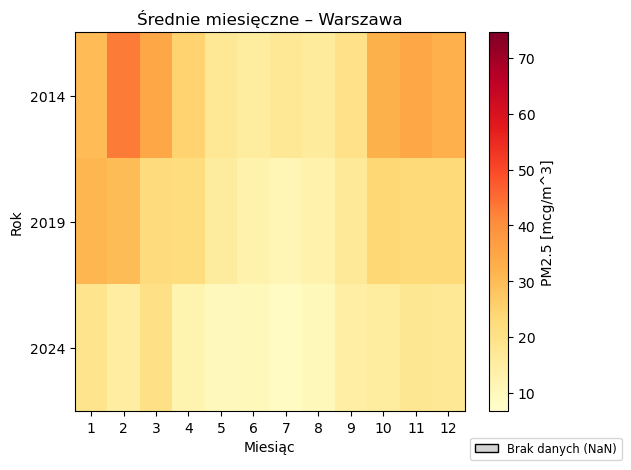

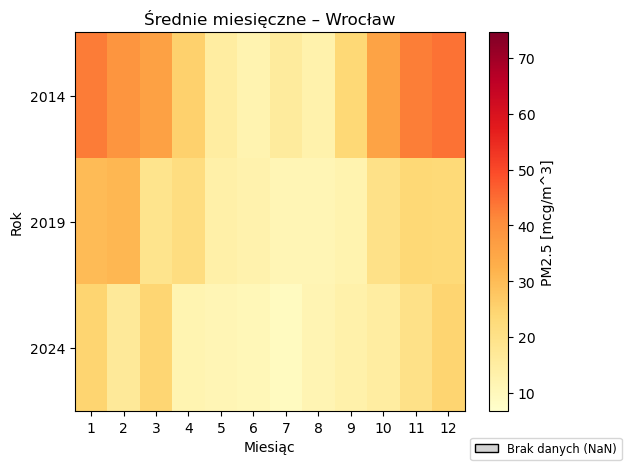

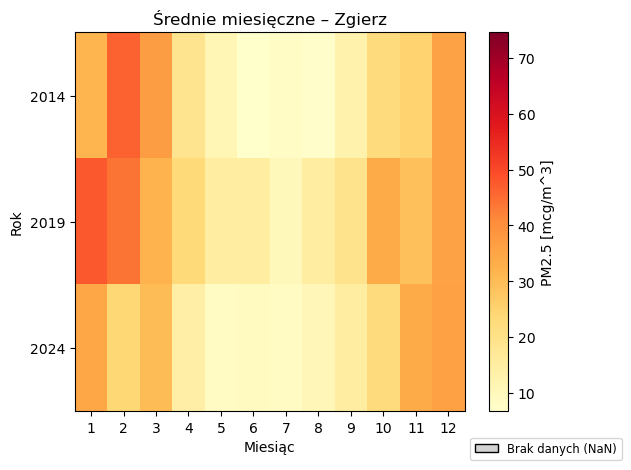

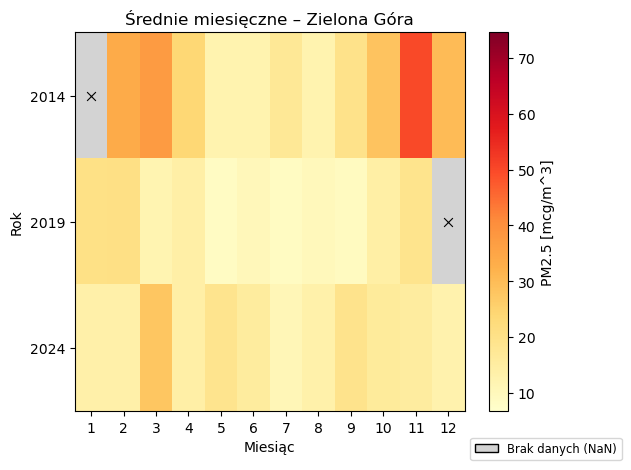

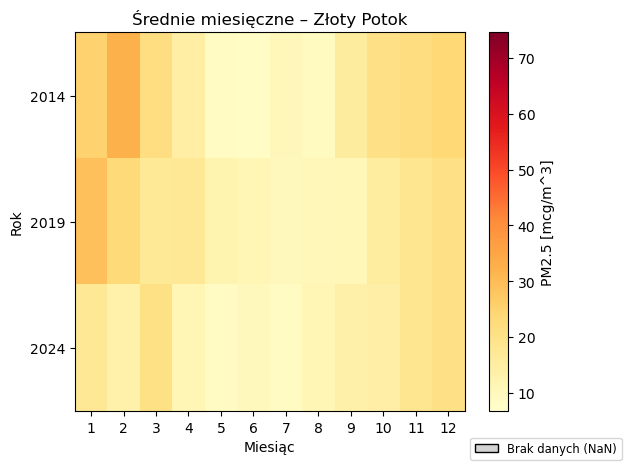

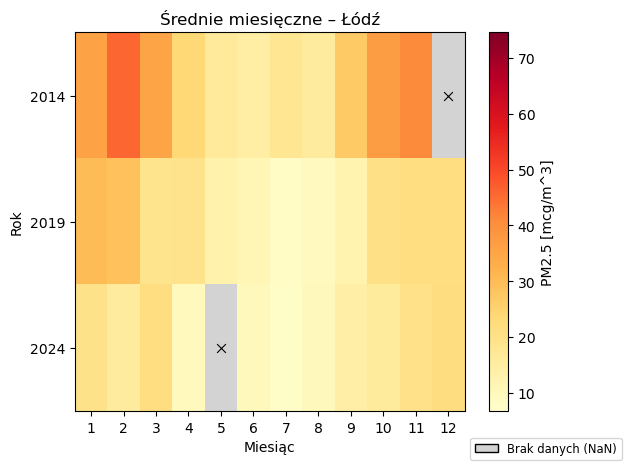

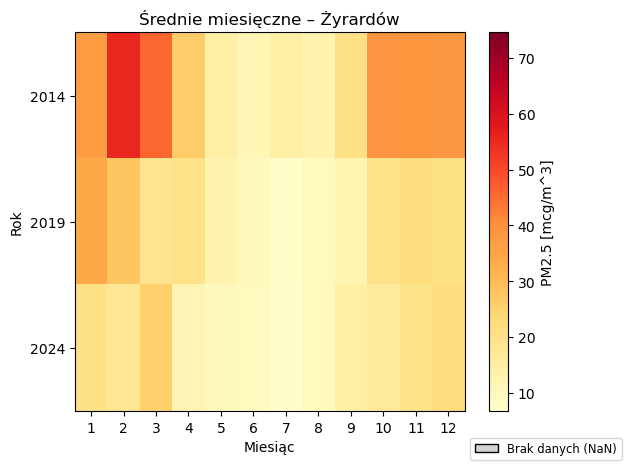

In [36]:
plot_city_monthly_heatmaps(
    monthly_avg_city,
    cities=city_data_combined.columns.to_list(),
    years=[2014, 2019, 2024],
)

## Przekroczenia norm

In [37]:
EXCLUDE_STATIONS = ["MzSiedKonars", "PmGdaLeczkow"] # wielomiesięczne przerwy w danych
days_over = count_days_over_threshold(data_combined.drop(EXCLUDE_STATIONS, axis=1), 15, years=(2014, 2019, 2024))
days_over

year,2014,2019,2024
station,,,
DsWrocAlWisn,255,180,134
KpBydPlPozna,218,218,108
LdLodzCzerni,285,183,128
LdZgieMielcz,186,244,189
LuZielKrotka,218,108,145
MpKrakAlKras,351,291,178
MpKrakBulwar,264,203,152
MzLegZegrzyn,250,207,121
MzPlocMiReja,219,188,131


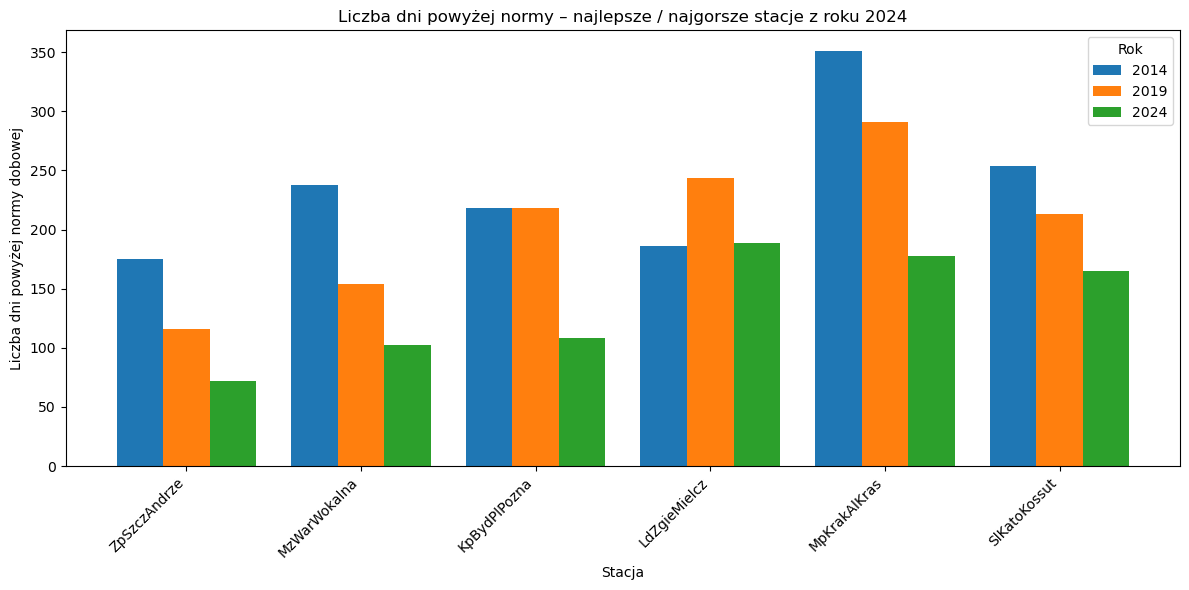

In [38]:
plot_extreme_stations_days_over(days_over, year_ref=2024,
                                years=(2014, 2019, 2024), n=3)

## Podsumowanie i Interpretacja

Na podstawie danych można stwierdzić, że sytuacja w zakresie stężenia pyłów **PM2.5** się poprawia na przestrzeni lat. Zdecydowanie widać pogorszenie sytuacji w okresie grzewczym, związanym z emisją pyłów przez prywatne ogrzewanie, które wedle mojej wiedzy, jest wysoko-emisje i przede-wszystkim odpowiedzialne za tak zwany smog. Widać tutaj skutek dotacji mających na celu wymienianie pieców cieplnych na nowoczesne.

Dodatkowo, sytuacja jest różna w różnych badanych regionach. Wynika to prawdopodobnie z czynników socjo-ekonomicznych (koszt wymiany pieca, ogrzewanie centralne, brak poczucia potrzeby dbania o środowisko), a także z uwarunkowania geograficznego (tj. faktu że niektóre miejscowości, są *uwięzione* przez uwarunkowanie terenowe, w taki sposób że zimą, podczas zwiększonej emisji, nie ma na tyle silnego wiatru, bądź jego kierunek nie pozwala na *wywianie* zanieczyszczeń)

### Suchy opis

- Progresywny spadek stężeń w kolejnych latach obserwowany w całym kraju - prawdopodobnie efekt zmian w technologiach grzewczych, spadek udziału paliw stałych (+ możliwe, że również łagodniejsze zimy)
- Silny efekt sezonowości - wzrost w miesiącach jesienno-zimowych - Prawdopodobnie wpływ "niskiej emisji" w sezonie grzewczym
- Wysokie zróżnicowanie stacji w miesiącach jesienno-zimowych, latem spadek we wszystkich stacjach do podobnego poziomu - Prawdopodobnie efekty zróżnicowanych lokalnie metod grzewczych, zróżnicowany udział paliw stałych i pieców starszej generacji
- Wspólny punkt odniesienia latem - prawdopodobnie efekt niższego zróżnicowania stałych źródeł zanieczyszczeń, głównie transportu
- Zróżnicowanie geograficzne: mniejsze poziomy w miejscowościach nadmorskich i na północy kraju (Gdańsk, Szczecin), wyróżniające się negatywnie miasta południa kraju (Kraków, Katowice)
- Ostatni wykres z przekroczeniami dziennymi również wskazuje że spadek stężeń występuje zarówno w "najlepszych" jak i "najgorszych" stacjach